[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hendersonneurolab/CogAI_Fall2025/blob/master/Lab02_CNNs.ipynb)

## Week 2: Convolutional Neural Networks (CNNs)

In this tutorial, we'll work with convolutional neural networks.

1. Construct a simple CNN using PyTorch and train it on the Fashion-MNIST dataset.
2. Work with a larger pre-trained CNN (AlexNet) and test its performance on object categorization.
3. Explore the internal representations of CNNs, including kernels and feature maps.

**Learning objectives:**
- Understand the key steps involved in neural network training
- Understand the inputs and outputs to an image classifier
- Develop an intuition for the CNN architecture and how it works

# Part 1: Training a simple image classifier

In [1]:
# Start with import statements - we need several libraries from torch
# Torch = PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import requests
from PIL import Image
import requests
from io import BytesIO
from PIL import Image

# Check if CUDA (GPU) is available - this will speed up training significantly
# If it says "cpu", use the menu at top right to select: "change runtime type"
# Then choose: T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')



Using device: cuda
GPU: Tesla T4


**Step 1: Preparing the data**

In PyTorch, there are several image datasets conveniently available by default. [Fashion-MNIST](https://docs.pytorch.org/vision/0.22/generated/torchvision.datasets.FashionMNIST.html) is one of these. It includes images of clothing items in 10 different categories.

Our goal is to create a model that can predict which of the 10 categories each image belongs to.

In the following code, we're going to create a "dataset" object that organizes the information about our dataset. Then we're going to create a "dataloader" object that handles the loading and batching of our images during model training.

For more background, see: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [2]:
# Fashion-MNIST has 10 classes of clothing items
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# this is where data files are stored.
# this ./data actually indicates a temp directory that will be deleted when your colab session ends.
data_root = './data'

def prepare_data(batch_size=128):
    """
    Prepares the Fashion-MNIST dataset for training and testing.
    """

    # Data preprocessing pipeline
    # Here we're creating a set of "transforms". These are functions that get
    # applied to each image, before it goes into the CNN.
    transform = transforms.Compose([
        transforms.ToTensor(),                    # Convert to tensor [0,1]
        transforms.Normalize((0.2860,), (0.3530,))  # Normalize to mean=0, std=1
    ])
    # Why these transforms?
    # - ToTensor(): Converts PIL images to PyTorch tensors and scales from [0,255] to [0,1]
    # - Normalize(): Centers the data around 0, which helps neural networks train better
    #   The values (0.2860,) and (0.3530,) are the mean and std of Fashion-MNIST

    # Download and load training data
    # We're making a dataset object here - this holds information about the image files.
    # Fashion-MNIST: 60,000 training images, 10,000 test images, 28x28 pixels each
    train_dataset = torchvision.datasets.FashionMNIST(
        root=data_root,
        train=True,
        download=True,        # Downloads dataset if not present
        transform=transform
    )

    test_dataset = torchvision.datasets.FashionMNIST(
        root=data_root,
        train=False,
        download=True,
        transform=transform
    )

    # Create DataLoader here.
    # DataLoader is created from the dataset object.
    # It handles batching, shuffling, and parallel loading
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,         # Shuffle training data each epoch
        num_workers=2,        # Parallel data loading (adjust based on your CPU)
        pin_memory=True       # Speeds up GPU transfer
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,        # No need to shuffle test data
        num_workers=2,
        pin_memory=True
    )

    return train_loader, test_loader, train_dataset, test_dataset


# Here we call the above function, making our dataset and dataloader objects.
train_loader, test_loader, train_dataset, test_dataset = prepare_data(batch_size=128)



100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.0MB/s]


In [3]:
# Check out what's in the datasets...how big are they?
train_dataset, test_dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.286,), std=(0.353,))
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.286,), std=(0.353,))
            ))

Let's view a couple of the images here....

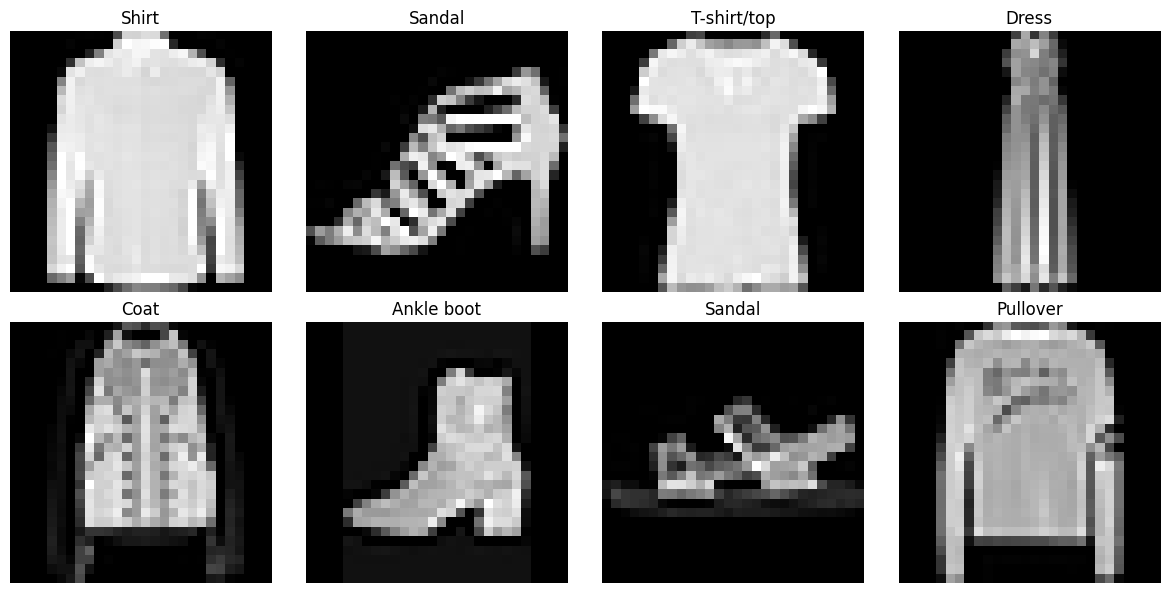

Image shape: torch.Size([1, 28, 28])
Batch shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


In [4]:

# Get one batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

num_samples = 8
for i in range(num_samples):
    # Convert tensor back to numpy for visualization
    # We need to denormalize: pixel = (normalized_pixel * std) + mean
    img = images[i].squeeze()
    img = img * 0.3530 + 0.2860  # Denormalize
    img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{class_names[labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {images[0].shape}")  # Should be [1, 28, 28]
print(f"Batch shape: {images.shape}")     # Should be [batch_size, 1, 28, 28]
print(f"Labels shape: {labels.shape}")    # Should be [batch_size]



**Step 2: Define the CNN model**

Now we will create the architecture of the model.

- This CNN model consists of several sequential layers: convolutional layers, followed by a nonlinearity (ReLU), followed by maxpooling layers. Last, there is a series of fully connected layers.

Reminder of some key terms here:
- **Architecture**: the overall connectivity or wiring of the CNN. Components of the architecture include:
  - Convolutional layer: scans the image with a set of 2D filters.
  - ReLU: a nonlinearity that is applied after the convolutional layers, taking out any negative values.
  - Max-pooling layer: take maximum values within spatial regions; makes the feature map smaller.
  - Fully-connected layer: every unit connects to every other unit.
- **Weights**: the parameters of the CNN. These are the actual values that are used in each operation, such as convolutions and fully-connected layers. Weights are learned during model training.



The building blocks of the model come from the `nn` module in PyTorch. This has many built in functions to create different types of layers: https://docs.pytorch.org/docs/stable/nn.html

- The model is created as a "FashionCNN" object.
- It has a method called "forward". The forward method is what gets used when you run the FashionCNN model. For example if you run: `FashionCNN(x)`, then x will be input to the forward method.



In [5]:

class FashionCNN(nn.Module):
    """
    Our Convolutional Neural Network for Fashion-MNIST classification.

    Architecture breakdown:
    - 2 Convolutional blocks (Conv -> ReLU -> MaxPool)
    - 3 Fully connected layers with dropout for regularization
    - Output layer with 10 units (one for each class)
    """

    def __init__(self):
        super(FashionCNN, self).__init__()

        # ====================================================================
        # CONVOLUTIONAL LAYERS
        # ====================================================================

        # First convolutional block
        # Input: 1x28x28 (1 channel, 28x28 pixels)
        self.conv1 = nn.Conv2d(
            in_channels=1,      # Grayscale images have 1 channel
            out_channels=32,    # We want 32 feature maps
            kernel_size=3,      # 3x3 filters
            padding=1           # Padding to maintain spatial dimensions
        )
        # After conv1: 32x28x28
        # After maxpool1: 32x14x14

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,    # More feature maps for richer representations
            kernel_size=3,
            padding=1
        )
        # After conv2: 64x14x14
        # After maxpool2: 64x7x7

        # Max pooling reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # ====================================================================
        # FULLY CONNECTED LAYERS
        # ====================================================================

        # Calculate input size for first linear layer
        # After 2 max pooling operations: 28 -> 14 -> 7
        # So we have 64 feature maps of size 7x7 = 64 * 7 * 7 = 3136

        self.fc1 = nn.Linear(64 * 7 * 7, 128)   # First hidden layer
        self.fc2 = nn.Linear(128, 64)            # Second hidden layer
        self.fc3 = nn.Linear(64, 10)             # Output layer (10 classes)

        # Dropout for regularization - randomly sets some neurons to 0 during training
        # This prevents overfitting by making the model more robust
        # self.dropout = nn.Dropout(0.5)  # 50% dropout rate
        self.dropout = nn.Dropout(0.1)  # 10% dropout rate

    def forward(self, x):
        """
        Forward pass through the network.
        This defines how data flows through our model.
        """

        # First convolutional block: Conv -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 14, 14]

        # Second convolutional block: Conv -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # [batch, 64, 7, 7]

        # Flatten for fully connected layers
        # View reshapes the tensor: -1 means "infer this dimension"
        x = x.view(-1, 64 * 7 * 7)  # [batch, 3136]

        # First fully connected layer with ReLU and dropout
        x = F.relu(self.fc1(x))     # [batch, 128]
        x = self.dropout(x)         # Apply dropout (only during training)

        # Second fully connected layer with ReLU and dropout
        x = F.relu(self.fc2(x))     # [batch, 64]
        x = self.dropout(x)

        # Output layer - no activation here, we'll use CrossEntropyLoss
        # CrossEntropyLoss applies softmax internally
        x = self.fc3(x)             # [batch, 10]

        return x



Quick test of the model: just pass one batch of images in.

In [6]:
# Make our CNN: it's an instance of this model class.
model = FashionCNN()
# Note that this model has NOT yet been trained.
# It is initialized with weights that are random.

# Get one batch of data (128 images, 128 labels)
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Forward pass: put images into model, get predictions
output = model(images)

print(output.shape)


torch.Size([128, 10])



Output contains the predicted probability assigned to each class by the model:

[128 x 10]
- 128 = image batch size
- 10 = number of classes


---

***Question 1:***

Write code to compute the accuracy of the model on this batch.

Hint: Use the variables "output" and "labels". To get the predicted labels, we want to find the category the model assigned the highest probability to.

In [7]:
# answer here
_, maxIndicies = torch.max(output, 1)
print(maxIndicies)
matched = (maxIndicies == labels).sum().item()
print(matched)
labelSize = labels.size(0)
print(labelSize)
accuracy = matched / labelSize
print(accuracy)
print(f"Batch Accuracy: {accuracy*100:.2f}%")

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5])
11
128
0.0859375
Batch Accuracy: 8.59%


How well did its predicted labels align with the real labels? Does this make sense?



They did not align very well a the batch accuracy came out to be less than 10% (batch accuracy changes each time the code is ran). This makes sense as the model has not been trained yet (weights are random), meaning that the algorithm is just guessing and the predictions are random.



---



**Step 3: Create training and evaluation procedures**

Now we will create the functions needed for model training.

Reminder of some key terms here:

- Batch = a group of images that are processed together by the CNN.
- Step = processing one batch of images. A step includes:
  1. Forward pass: we pass the batch into the CNN, and collect outputs.
  2. Computing loss: we determine how accurate the outputs were.
  3. Computing gradients: we determine how much each weight should change to improve the loss. Uses backpropagation.
  4. Updating weights: we adjust the weights of the CNN, to make it better. The new weights get used on the next step.
- Epoch = one pass over the entire training dataset (includes multiple steps).



In [8]:
# Make a function for training, just one epoch

def train_epoch(model, train_loader, optimizer, device):
    """
    Trains the model for one epoch (one pass through all training data).

    Returns:
        avg_loss: Average loss for this epoch
        accuracy: Training accuracy for this epoch
    """
    model.train()  # Set model to training mode (enables dropout, batch norm, etc.)

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # tqdm creates a progress bar
    progress_bar = tqdm(train_loader, desc='Training', leave=False)

    # loop over the whole training dataset, in batches.

    for batch_idx, (data, target) in enumerate(progress_bar):
        # Move data to GPU if available
        data, target = data.to(device), target.to(device)

        # Zero the gradients from the previous batch
        # PyTorch accumulates gradients by default
        optimizer.zero_grad()

        # Step 1 - Forward pass: compute predictions
        output = model(data)

        # Step 2 - Compute loss
        # Here, this is based on cross-entropy loss.
        # It's a measure of how well the output probabilities have captured
        # the actual labels.
        # CrossEntropyLoss combines softmax and negative log-likelihood
        # It's perfect for multi-class classification
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)

        # Step 3 - Compute gradients
        loss.backward()
        # This is where we do "backpropagation". Sometimes called the backward pass.

        # Step 4 - Update weights of the model, based on the gradients
        optimizer.step()


        # Statistics for monitoring
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)  # Get class with highest probability
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct_predictions / total_samples:.2f}%'
        })

    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct_predictions / total_samples

    return avg_loss, accuracy



In [9]:
# Now make a function for evaluation, just for one epoch

def evaluate_epoch(model, test_loader, device):
    """
    Evaluates the model on test data.

    Returns:
        avg_loss: Average test loss
        accuracy: Test accuracy
        class_accuracies: Accuracy for each class
    """
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)

    test_loss = 0
    correct = 0
    total = 0

    # Track predictions for each class
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():  # Disable gradient computation for faster inference
        for data, target in tqdm(test_loader, desc='Evaluating', leave=False):
            data, target = data.to(device), target.to(device)

            output = model(data)
            criterion = nn.CrossEntropyLoss()
            test_loss += criterion(output, target).item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Per-class accuracy
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    # Calculate per-class accuracies
    class_accuracies = []
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100. * class_correct[i] / class_total[i]
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0.0)

    return avg_loss, accuracy, class_accuracies



**Step 4: Run the training procedure**


Here we will train the model for a number of epochs. We will use the training and eval functions that we just defined.

Reminder of key terms here:

- Loss: a measure of how badly the model has done on our task. Here, it's a classification task, so it captures classification accuracy, but in other scenarios it could capture some other task. The goal of training is to make the loss as low as possible.
- Gradients: for each model parameter, which direction should we change it to improve the model's loss?
- Optimizer: an algorithm that defines how we will update weights based on gradients, to improve loss.


Note: this cell can take a while to run, especially if you're using a CPU. Make sure you connect to the GPU, and it should take <5 minutes.

In [10]:

# num_epochs = 10;
num_epochs = 5;
learning_rate = 0.001;

# Move model to GPU if available
model = model.to(device)

# Adam optimizer - adaptive learning rate, works well in practice
# Alternative: SGD with momentum
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track training history
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Evaluate on train and test set - before any training.
train_loss, train_acc, train_class_accs = evaluate_epoch(model, train_loader, device)
test_loss, test_acc, class_accs = evaluate_epoch(model, test_loader, device)

# Print out how badly it did before we performed any training.
# This is like a "random" model
print(f'Before training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
print(f'Before training - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Record history
train_losses.append(train_loss)
train_accuracies.append(train_acc)
test_losses.append(test_loss)
test_accuracies.append(test_acc)

print(f"\nStarting training for {num_epochs} epochs...")
print(f"Training on {device}")

start_time = time.time()

# loop over however many epochs we're doing
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Train for one epoch
    # Calling that function we made earlier.
    train_loss_running, train_acc_running = train_epoch(model, train_loader, optimizer, device)

    # Evaluate on train and test set
    train_loss, train_acc, train_class_accs = evaluate_epoch(model, train_loader, device)
    test_loss, test_acc, class_accs = evaluate_epoch(model, test_loader, device)

    # Record history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Print epoch results
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # Print per-class accuracies every few epochs
    if (epoch + 1) % 5 == 0:
        print("\nPer-class accuracies:")
        for i, acc in enumerate(class_accs):
            print(f'{class_names[i]}: {acc:.2f}%')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')


Before training - Train Loss: 2.3032, Train Acc: 10.00%
Before training - Test Loss: 2.3031, Test Acc: 10.00%

Starting training for 5 epochs...
Training on cuda

Epoch 1/5
--------------------------------------------------


Train Loss: 0.3240, Train Acc: 88.09%
Test Loss: 0.3525, Test Acc: 87.25%

Epoch 2/5
--------------------------------------------------


Train Loss: 0.2540, Train Acc: 90.65%
Test Loss: 0.2945, Test Acc: 89.12%

Epoch 3/5
--------------------------------------------------


Train Loss: 0.2240, Train Acc: 91.79%
Test Loss: 0.2679, Test Acc: 90.19%

Epoch 4/5
--------------------------------------------------


Train Loss: 0.1944, Train Acc: 92.82%
Test Loss: 0.2624, Test Acc: 90.48%

Epoch 5/5
--------------------------------------------------


Train Loss: 0.1668, Train Acc: 93.94%
Test Loss: 0.2346, Test Acc: 91.48%

Per-class accuracies:
T-shirt/top: 84.70%
Trouser: 97.40%
Pullover: 87.80%
Dress: 93.50%
Coat: 89.20%
Sandal: 98.60%
Shirt: 73.20%
Sneaker: 95.20%
Bag: 97.90%
Ankle boot: 97.30%

Training completed in 180.04 seconds


In [11]:
# Getting the final performance of the model, once it's fully trained

_, final_accuracy, class_accuracies = evaluate_epoch(model, test_loader, device)

print(f"\nFinal test accuracy: {final_accuracy:.2f}%")

print("\nPer-class accuracies:")
for i, acc in enumerate(class_accuracies):
    print(f"{class_names[i]}: {acc:.2f}%")



Final test accuracy: 91.48%

Per-class accuracies:
T-shirt/top: 84.70%
Trouser: 97.40%
Pullover: 87.80%
Dress: 93.50%
Coat: 89.20%
Sandal: 98.60%
Shirt: 73.20%
Sneaker: 95.20%
Bag: 97.90%
Ankle boot: 97.30%


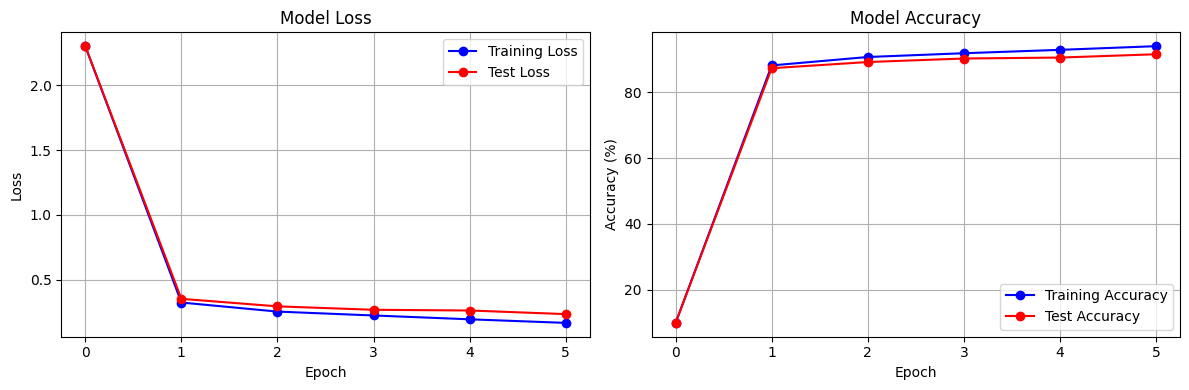

In [12]:
# Visualize the model's training progress over time

def plot_training_history(history):
    """
    Plots training and validation curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    epochs = range(0, len(history['train_losses']))
    ax1.plot(epochs, history['train_losses'], 'bo-', label='Training Loss')
    ax1.plot(epochs, history['test_losses'], 'ro-', label='Test Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curve
    ax2.plot(epochs, history['train_accuracies'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs, history['test_accuracies'], 'ro-', label='Test Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies
}
plot_training_history(history)


---

***Question 2:***

Describe the patterns of loss and accuracy over time. Why do they go up/down?

Are there any differences between the values of training vs. test accuracy? Why?

Model Loss shows that the amount of loss for both training loss and test loss go down drastically between Epoch 0 and 1, and then continues to decrease slowly from epoch 1 to 5. It went down because the weights were adjusted between epoch 0 and 1 to reduce the loss, and as we approach epoch 5, the algorithm is tweaking the weights little by little to further reduce the loss. Since both training loss and test loss follow a very similar trend, it tels us that the model is learning and generalizing well.

Model Accuracy shows that accuracy starts low at epoch 0 and drastically increases from epoch 0 to 1 and continues to increase slowly from epoch 1 to 5. There is a drastic increase because the weights are initially random so the accuracy is low, then the model processes the inputes, computes loss, and adjusts its weights using backpropagation and optimizer accordingly to minimize loss and maximize accuracy.



There are some slight differences between training accuracy and test accuracy. Training accuracy is slightly higher than test eaccuracy from Epoch 1 to 5. We can see in the Modle accuracy graph that in Epoch 5, training accuracy is around 98% while test accuracy seems to be around 96%. Training accuracy tends to be slightly higher than test accuracy as the model is working with input that it has already been exposed and adjusted to.




---



# Part 2: Loading a large pre-trained model

**Step 1: Loading a pre-trained AlexNet model.**

[AlexNet](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html) is a popular deep CNN architecture. It can work with larger, more complex images than the smaller model we used in Part 1. Because the model is so large and takes a lot of time and compute to train, we'll load a pre-trained model here and examine it.

PyTorch has many built-in pretrained models that can be loaded in just a few lines.

Learn more about the other models available here:
https://docs.pytorch.org/vision/main/models.html

In [13]:
# Load pre-trained model
# It prints out the structure and composition of the model.
print("Loading AlexNet model...")
model = models.alexnet(pretrained=True)
model.eval()  # Set to evaluation mode


Loading AlexNet model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 186MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Step 2: Passing an example image into the model**

Using the pre-trained model, we can examine which categories it predicts for a given image.

First we're going to download an example image.


In [19]:
# Helper function for image downloads
def download_image(url, filepath):
    try:
        headers = {
              'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
          }
        response = requests.get(url, headers=headers, timeout=10)
        # response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raises exception for bad status codes

        # Verify it's an image
        content_type = response.headers.get('content-type', '')
        if not content_type.startswith('image/'):
            print(f"Warning: Content-Type is {content_type}, not an image")
            return False

        with open(filepath, 'wb') as f:
            f.write(response.content)

        # Verify file size
        if os.path.getsize(filepath) < 100:  # Very small files are likely errors
            print("Warning: Downloaded file is suspiciously small")
            return False

        return True

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return False

In [23]:
# Mount our Google Drive storage here
import os
from google.colab import drive
import requests

drive.mount('/content/drive')

# Navigate to the Colab Notebooks folder
colab_notebooks_path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(colab_notebooks_path)
os.makedirs('CogAI/images', exist_ok=True)
images_folder = os.path.join(colab_notebooks_path, 'CogAI', 'images')

# Your image URL
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/American_Eskimo_Dog.jpg/256px-American_Eskimo_Dog.jpg'
# What we want to name the file
name = 'Dog.jpg'

# This is the full path to the image, on drive.
file_path = os.path.join(images_folder, name)
print(file_path)
success = download_image(image_url, file_path)
print('Success = %s'%success)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/CogAI/images/Dog.jpg
Success = True


Optional - upload your own image here:

- Go to: https://drive.google.com/drive/
- Navigate to "Colab Notebooks > CogAI > images"
- Upload your image to this folder
- Edit "name" in the code below:

In [59]:
# run this IF you uploaded your own image (otherwise, skip to next cell)
# What's your file called?
name = 'RedCup.jpg'
# This is the full path to the image, on drive.
file_path = os.path.join(images_folder, name)

Load and pre-process the image for the network:

In [60]:
# Define image preprocessing pipeline
# This ensures the image is the correct size and shape for our network.
# If it's the wrong shape/size, you'll get errors.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

preproc_simple = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

# Load the image here:
image = Image.open(file_path).convert('RGB')
image_orig = image.copy()

image_cropped = preproc_simple(image)



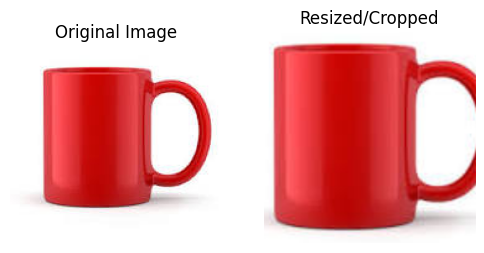

In [61]:

# Display original image
plt.figure(figsize=(6, 6));

plt.subplot(1,2,1);
plt.imshow(image);
plt.title('Original Image')
plt.axis('off');
# plt.show()

plt.subplot(1,2,2);
plt.imshow(image_cropped);
plt.title('Resized/Cropped');
plt.axis('off');
# plt.show()
#


In [62]:
# Loading info about the ImageNet object categories here.
# Because this model was trained on ImageNet, it outputs labels 1-1000, which
# correspond to object categories.
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)
labels = response.text.strip().split('\n')
labels = np.array(labels)
labels.shape
# print a few labels...
labels[0:10]


array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich'],
      dtype='<U30')

In [63]:
# Convert the image into a tensor format, and pre-process it for the CNN
input_tensor = preprocess(image).unsqueeze(0)

# Now pass it into the model, and get the outputs
output = model(input_tensor)

# Outputs consist of probabilities for each image class in imagenet.
# We're going to find the highest probability classes by sorting.
topn = torch.argsort(output, descending=True)[0][0:5]

for ni, nn in enumerate(topn):
  print('Prediction #%d: %d, %s'%(ni, nn, labels[nn]))

# Are these good predictions?

Prediction #0: 504, coffee mug
Prediction #1: 968, cup
Prediction #2: 725, pitcher
Prediction #3: 899, water jug
Prediction #4: 505, coffeepot



---
***Question 3:***

Go back up to the start of this section, and change the image to something else. You can find an image on google and copy the url, and enter it as `image_url`. Or, follow the instructions above to upload something from your computer.

 Does the network make a good guess for this image? Try to find an image that the network gets incorrect.

[answer here]
I ran an image of a red mug and a llama through the model. The results of the red mug came out as "coffee mug, cup, pitcher, water jug, coffeepot" and the results of the llama came out as "Bedlington terrier, llama, kuvasz, bighorn, ram". The predictions of the red mug are relatively accurate as it outputs an object that can hold liquid. However, the predictions are slightly less accurate for llama as the only 1/5 predictions were llama and the other 4/5 were either dog breeds or sheep/ram.



---




***Question 4:***

Now go back to the top of the notebook (`model = models.alexnet(pretrained=True))` and change the variable `pretrained=False`. Then re-run the predictions on this image. How do the predictions change? Why?


[answer here]




---



Put everything back. Back to the original image and the fully-trained model.

In [64]:
file_path = os.path.join(images_folder, 'Dog.jpg')

image = Image.open(file_path)
image_orig = image.copy()

image_cropped = preproc_simple(image)
input_tensor = preprocess(image).unsqueeze(0)

print("Loading AlexNet model...")
model = models.alexnet(pretrained=True)

# You can also try pre-trained=False here if you want - how do the kernels change?
# model = models.alexnet(pretrained=False)
model.eval()  # Set to evaluation mode


Loading AlexNet model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Step 3: Investigating the inner workings of the model.**

Now we're going to visualize the internal representations of the model (i.e., activations) in response to an image.

Reminder about some key terms:
- Weights: Parameters of the model that define how it processes the image. Learned during training.
- Activations: Response of model units to a specific image.
- Kernel (i.e., filter): The set of weights that is slid across the image when the convolution operation is applied. Like a 2D image filter aimed at detecting one particular feature. There are multiple kernels per CNN layer.
- Feature maps: The set of activations resulting from convolution with one kernel. It's a spatial map that indicates where in the image the corresponding feature is located.

In [65]:
# Because we want to visualize activations, not just get the outputs of the model,
# we have to add another function here.

# Function to register hooks for activation extraction
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for all the conv layers
conv_layer_inds = [0,3,6,8,10]
conv_layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
for i, layer_name in enumerate(conv_layer_names):
    model.features[conv_layer_inds[i]].register_forward_hook(get_activation(layer_name))


# Forward pass to extract activations
print("Running forward pass...")
with torch.no_grad():
    output = model(input_tensor)
print('Done')

Running forward pass...
Done


Let's visualize a few of the kernels from the first convolutional layer (conv1). The middle column shows the kernel, the right column shows the corresponding feature map activations. Basically, the middle column is "slid" across the image to create the right column.

Text(0.5, 0.98, 'conv1')

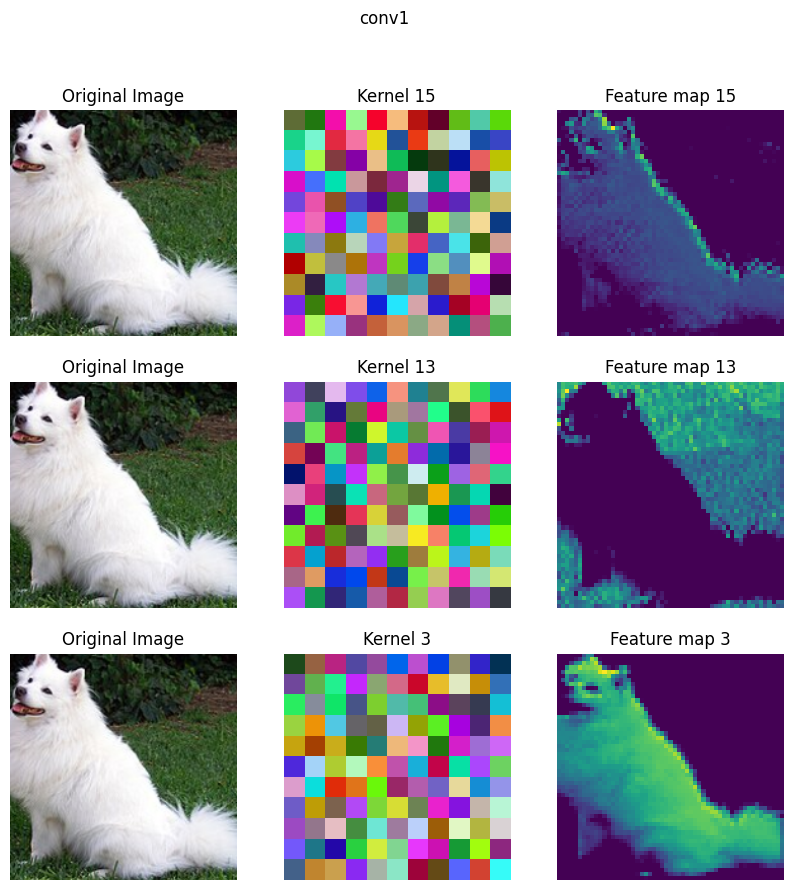

In [66]:
layer = model.features[0]
layer_weights = layer.weight.data.clone()

num_kernels_plot = 16;
kernels = layer_weights[:num_kernels_plot]

# Normalize kernels for visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

feature_maps = activations['conv1'].squeeze(0)  # Remove batch dimension

kk_plot = [14,12,2]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

pi=-1
for ki, kk in enumerate(kk_plot):

  pi+=1
  axes[pi].imshow(image_cropped)
  axes[pi].axis('off')
  # if ki==0:
  axes[pi].set_title('Original Image')

  pi+=1
  kernel = kernels[kk].permute(1, 2, 0).cpu().numpy()  # CHW to HWC
  axes[pi].imshow(kernel)
  axes[pi].axis('off')
  axes[pi].set_title('Kernel %d'%(kk+1))

  pi+=1
  axes[pi].imshow(feature_maps[kk])
  axes[pi].axis('off')
  axes[pi].set_title('Feature map %d'%(kk+1))

plt.suptitle('conv1')


---
***Question 5:***

What do we notice about the relationship between these kernels and their feature maps? How would you describe the feature that each kernel is "looking for"?

[answer here]



---



Now let's make the same plot but for a later layer (conv3). Notice in this case the kernels won't be in color. This is because the first layer has exactly 3 input channels (R, G, and B colors), so it's easy to plot them in color. But the later layers have more input channels, which don't correspond to color channels.

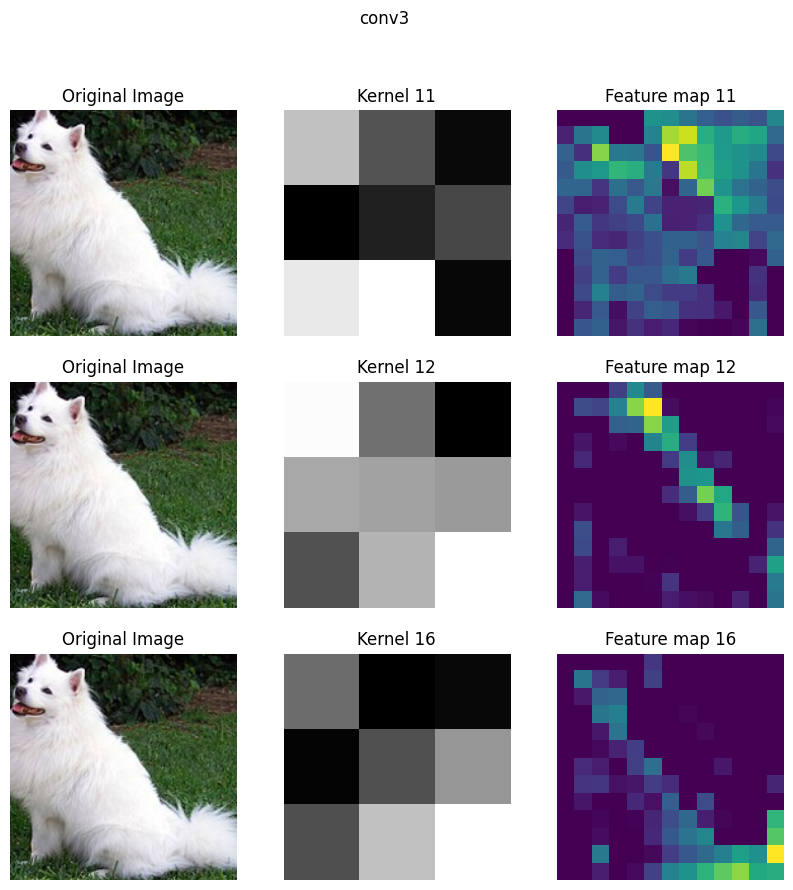

In [67]:

layer = model.features[6]
layer_weights = layer.weight.data.clone()

num_kernels_plot = 16;
kernels = layer_weights[:num_kernels_plot]

# Normalize kernels for visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

feature_maps = activations['conv3'].squeeze(0)  # Remove batch dimension

kk_plot = [10, 11, 15]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

pi=-1
for ki, kk in enumerate(kk_plot):

  pi+=1
  axes[pi].imshow(image_cropped)
  axes[pi].axis('off')
  # if ki==0:
  axes[pi].set_title('Original Image')

  pi+=1
  # the [0] index here takes weights for the first input channel
  # there are actually more, but we can't plot them all...
  kernel = kernels[kk][0].cpu().numpy()
  axes[pi].imshow(kernel, cmap='gray')
  axes[pi].axis('off')
  axes[pi].set_title('Kernel %d'%(kk+1))

  pi+=1
  axes[pi].imshow(feature_maps[kk])
  axes[pi].axis('off')
  axes[pi].set_title('Feature map %d'%(kk+1))

  plt.suptitle('conv3')



---
***Question 6:***

What are the differences between the conv3 feature maps and conv1 feature maps? What features do you think the conv3 filters are "looking for" in the image?

[answer here]



---



Let's plot more of the kernels and corresponding feature maps from each layer. Notice the variety of filters.



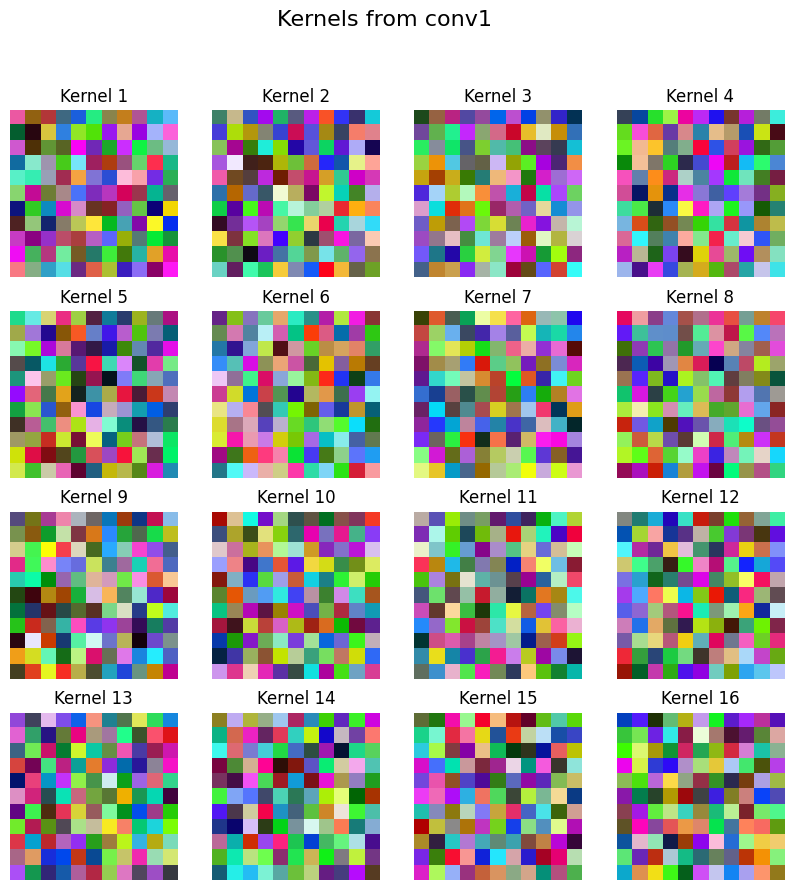

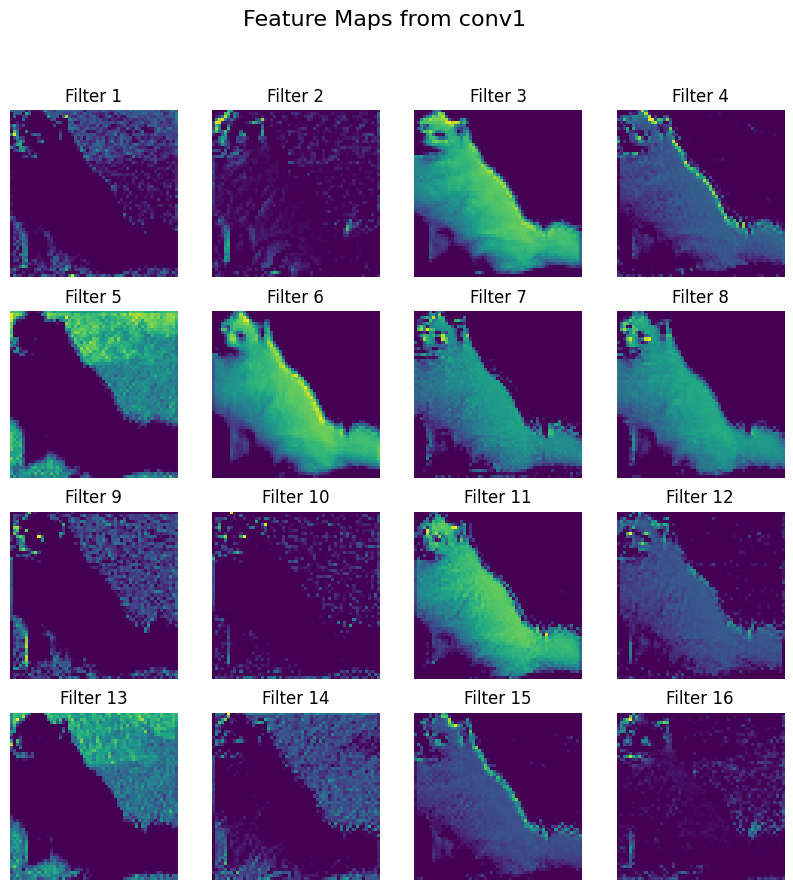

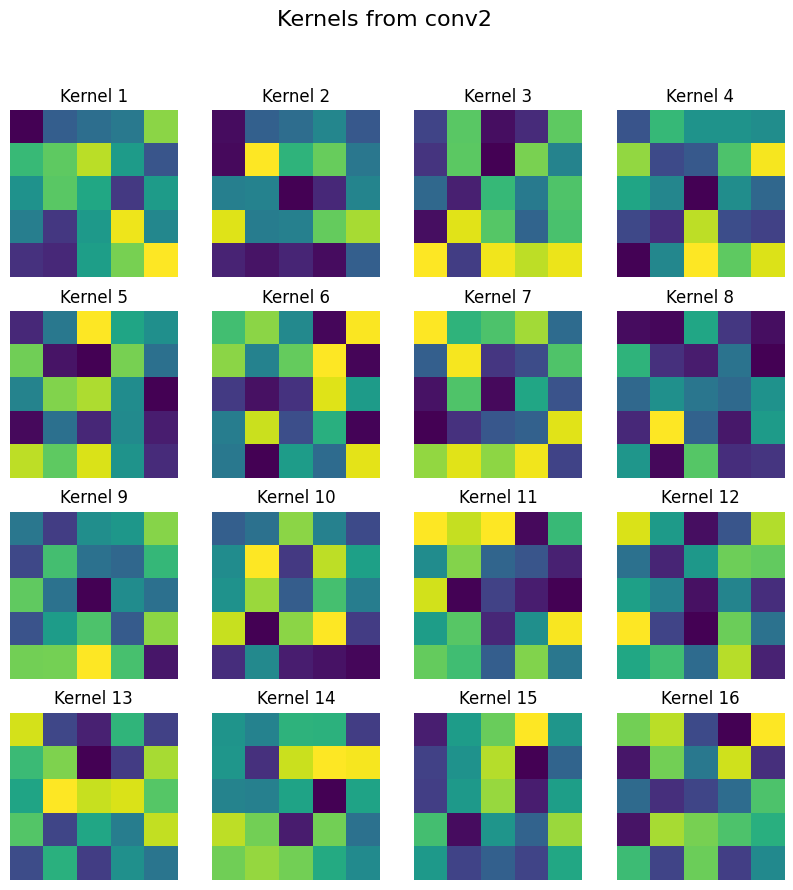

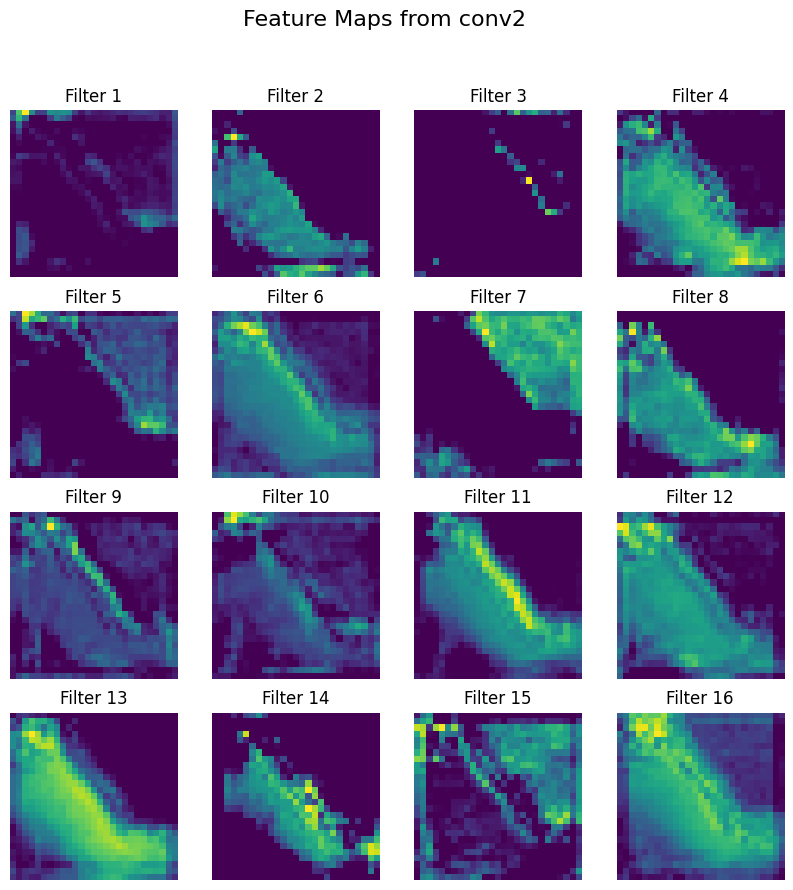

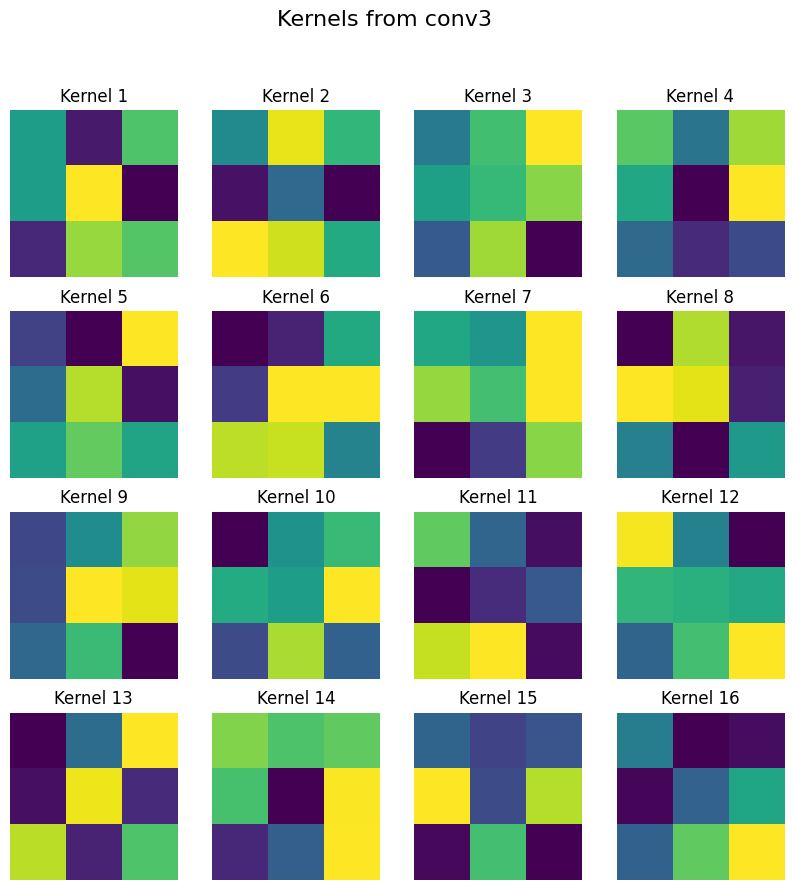

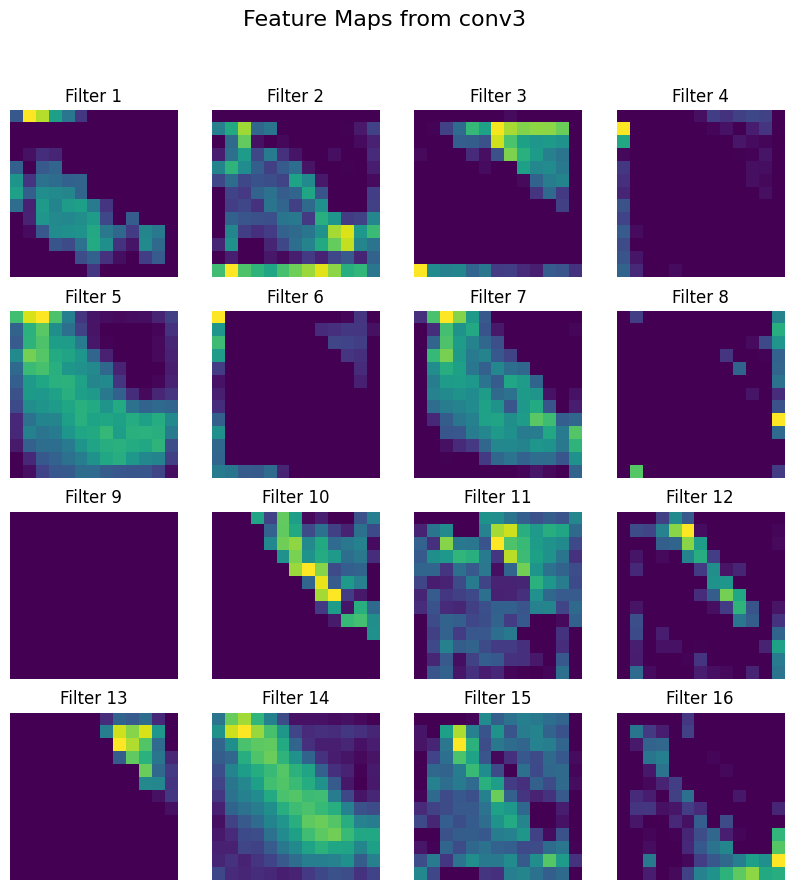

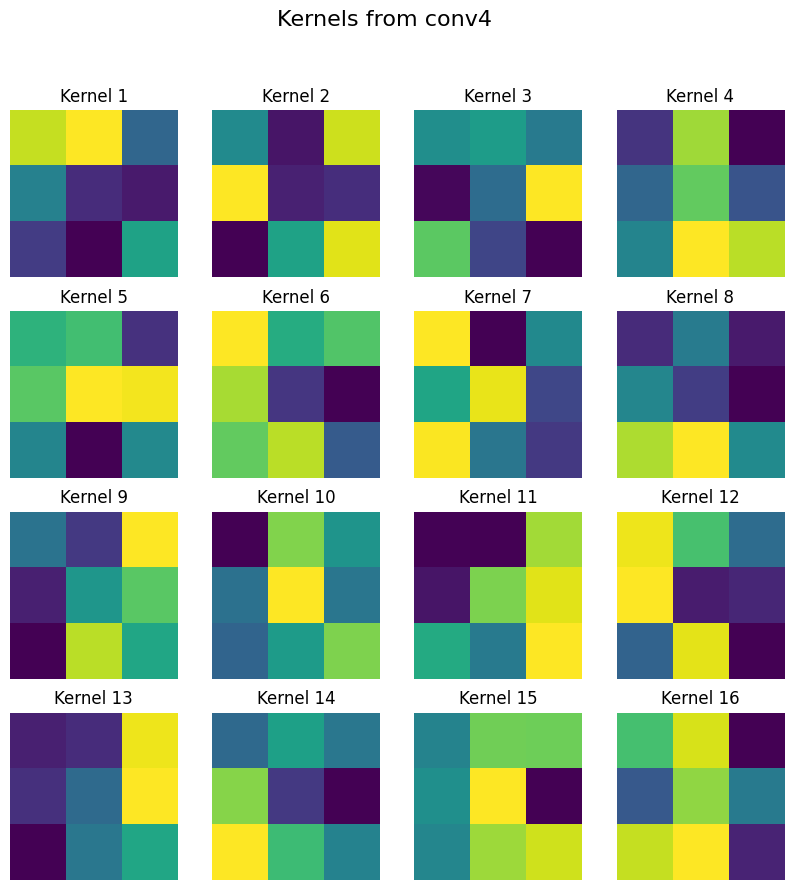

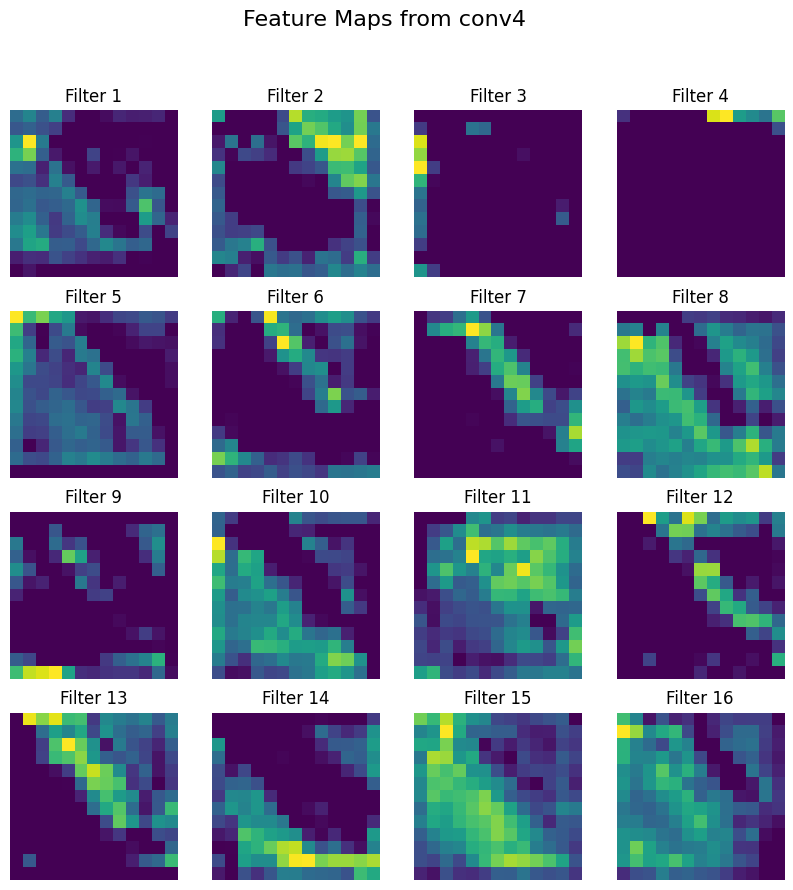

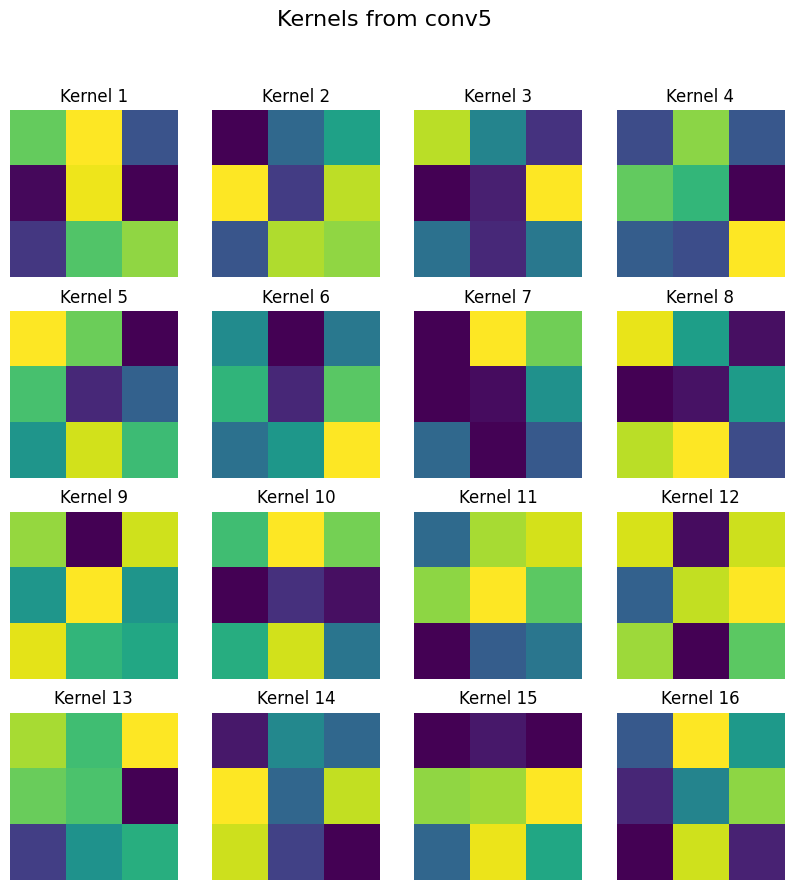

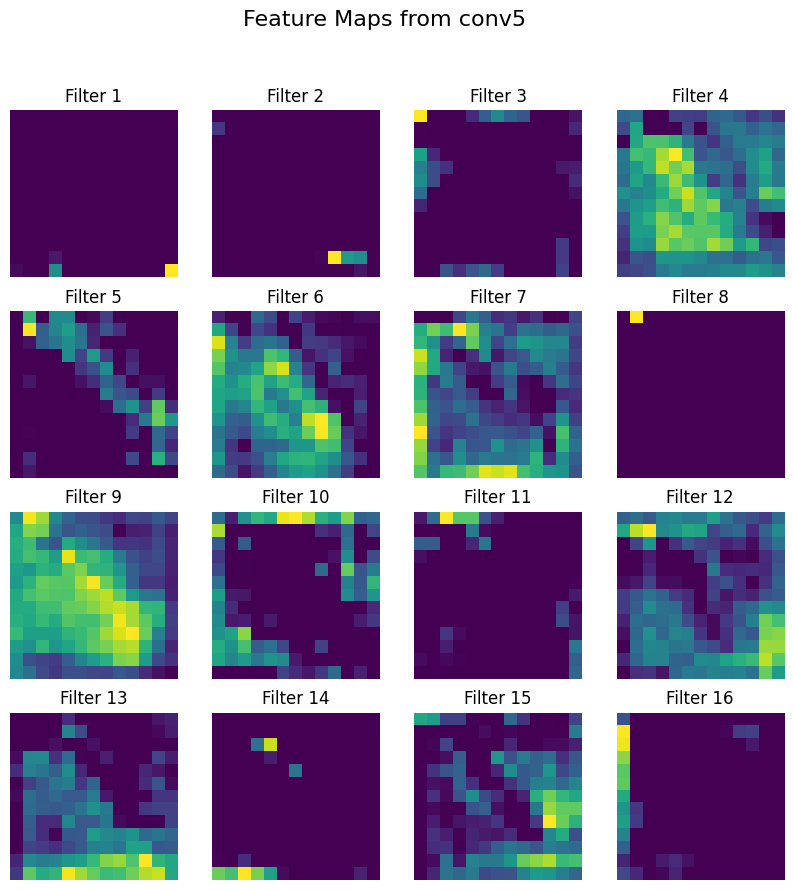

In [68]:
for li, ll, layer_name in zip(range(5), conv_layer_inds, conv_layer_names):

  layer = model.features[ll]
  layer_weights = layer.weight.data.clone()

  # how many of these to plot now?
  num_kernels_plot = 16;
  kernels = layer_weights[:num_kernels_plot]

  # Normalize kernels for visualization
  kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

  grid_size = int(np.ceil(np.sqrt(num_kernels_plot)))
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
  fig.suptitle(f'Kernels from {layer_name}', fontsize=16)

  for i in range(grid_size * grid_size):
      row, col = i // grid_size, i % grid_size
      if i < num_kernels_plot:
          if li==0:
            kernel = kernels[i].permute(1, 2, 0).cpu().numpy()  # CHW to HWC
          else:
            kernel = kernels[i][0].cpu().numpy()  # CHW to HWC
          # kernel = kernels[i].permute(1, 2, 0).cpu().numpy()  # CHW to HWC
          axes[row, col].imshow(kernel)
          axes[row, col].set_title(f'Kernel {i+1}')
      axes[row, col].axis('off')
  feature_maps = activations[layer_name].squeeze(0)  # Remove batch dimension

  fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
  fig.suptitle(f'Feature Maps from {layer_name}', fontsize=16)

  for i in range(grid_size * grid_size):
      row, col = i // grid_size, i % grid_size
      if i < num_kernels_plot:
          feature_map = feature_maps[i].cpu().numpy()
          axes[row, col].imshow(feature_map, cmap='viridis')
          axes[row, col].set_title(f'Filter {i+1}')
      axes[row, col].axis('off')

  # plt.tight_layout()
  # plt.show()


---
***Question 7:***

Let's connect this back to neuroscience!

For each of the plots we just made, describe the analogous component in visual cortex. In other words, what's the "brain inspiration" for these elements:
- Kernels
- Each pixel within a feature map
- Feature maps within each layer
- Feature maps from different layers

[answer here]


---




And keep in mind the caveat: this is just a loose, theoretical correspondence. AlexNet should not be interpreted as an accurate model of visual cortex. More on this in future classes...